In [1]:
using LightGraphs
using GraphPlot
using Plots
using ProgressBars
using Statistics
using LinearAlgebra

In [2]:
#'reasonable' parameters
gridsize=1450
pop=gridsize^2
p0=0.2 #a guess - tuned to match observed data 
p2=1/12 #revised infection rate with distancing measures
q=1/7 #"up to" two weeks
r0=1/14 #about two weeks for mild, 3-6 for severe
r2=1/4 #revised removal rate (now due to testing and isolation)
 #   ndays=120 #120 prediction (from patient(s) zere
 #   nsims=50 #50 runs
nseeds=5 #probably too many, consider dropping.



#got that working ... put it all together
function episim(net1, net2, ndays::Int64=120, nsims::Int64=50)
    
    state=Array{Int8,2}(undef,1,pop) #this is a bit wasteful, there must be a better categorical way to do this...
    state[1:pop].=1;
    state[rand((1:pop),(1,nseeds))].=2; #seeds should be exposed cases
    
    st=Array{UInt64,2}(undef,ndays,nsims)
    ex=Array{UInt64,2}(undef,ndays,nsims)
    fe=Array{UInt64,2}(undef,ndays,nsims)
    rm=Array{UInt64,2}(undef,ndays,nsims)
    st[1,1:nsims] .= count(x->x==1,state)
    ex[1,1:nsims] .= count(x->x==2,state)
    fe[1,1:nsims] .= count(x->x==3,state)
    rm[1,1:nsims] .= count(x->x==4,state)
    
    iter = ProgressBar(1:nsims)
    for j in iter
        net=net1
        #reinitialise the state vector
        state=Array{Int8,2}(undef,1,pop) #this is a bit wasteful, there must be a better categorical way to do this...
        state[1:pop].=1;
        state[rand((1:pop),(1,nseeds))].=2; #seeds should be exposed cases
        r=r0
        p=p0
        
        for i in 1:ndays

            for v in vertices(net)
                if state[v]==1
                    for n in all_neighbors(net, v)
                        if state[n]==3 && rand(Float64).<p
                            state[v]=2   #susceptible becomes exposed
                        elseif state[n]==14 && rand(Float64).<p
                            state[v]=2   #susceptible becomes exposed
                        
                        end
                    end
                elseif state[v]==2 && rand(Float64).<q
                    state[v]=13 #exposed becomes infectious
                elseif state[v]==3 && rand(Float64).<r
                    state[v]=14 #infectious becomes removed
                end
            end
            state[state.>10]= state[state.>10] .- 10

            st[i,j] = count(x->x==1,state)
            ex[i,j] = count(x->x==2,state)
            fe[i,j] = count(x->x==3,state)
            rm[i,j] = count(x->x==4,state)
            
            #########################################
            #switch network after 300 infections
            if fe[i,j]>300
                net=net2 #change network structure
                r=r2     #change the removal rate
                p=p2     #and the infection rate
            end
            #########################################
            
        end
    end
    
    return st, ex, fe, rm

end

episim (generic function with 3 methods)

In [3]:
bamodel=barabasi_albert(gridsize^2, 3, 2)
lattice=LightGraphs.grid((gridsize,gridsize),periodic=true)
wattstrog=watts_strogatz(gridsize^2, 4, 0.1) 

{2102500, 4205000} undirected simple Int64 graph

In [4]:
St,Et,It,Rt=episim(bamodel,wattstrog) #switch between scale free and lattice (i.e. mixing to diffusion)

100.0%┣██████████████████████████████████████████┫ 50/50 [05:41<00:00, 0.1 it/s]


(UInt64[0x00000000002014df 0x00000000002014df … 0x00000000002014df 0x00000000002014df; 0x00000000002014df 0x00000000002014df … 0x00000000002014db 0x00000000002014de; … ; 0x00000000001fffeb 0x00000000001ff23a … 0x00000000001ff281 0x0000000000200067; 0x00000000001fffe3 0x00000000001ff238 … 0x00000000001ff27c 0x0000000000200065], UInt64[0x0000000000000005 0x0000000000000004 … 0x0000000000000005 0x0000000000000004; 0x0000000000000005 0x0000000000000004 … 0x0000000000000007 0x0000000000000005; … ; 0x000000000000002f 0x000000000000001c … 0x000000000000002e 0x0000000000000016; 0x000000000000002a 0x0000000000000016 … 0x000000000000002d 0x0000000000000016], UInt64[0x0000000000000000 0x0000000000000001 … 0x0000000000000000 0x0000000000000001; 0x0000000000000000 0x0000000000000001 … 0x0000000000000002 0x0000000000000001; … ; 0x0000000000000017 0x000000000000001e … 0x000000000000001c 0x0000000000000012; 0x0000000000000020 0x000000000000001e … 0x000000000000001c 0x000000000000000c], UInt64[0x000000

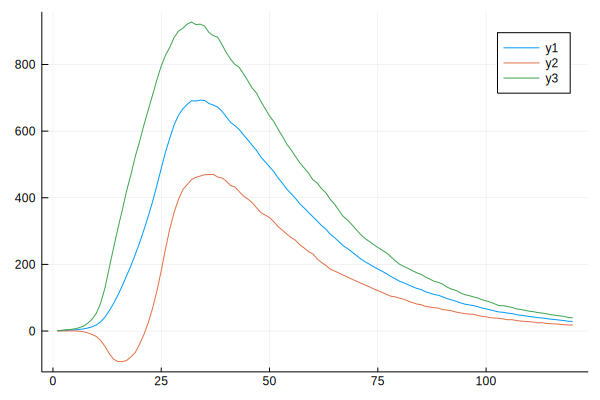

In [5]:
meany=mean(It,dims=2)
stdy=std(It,dims=2)
plot(1:120,[meany, meany-stdy, meany+stdy])

In [6]:
function plotquantiles(y,col,labl,qnt::Float64=0.3)
    nt,ny=size(y)
    low=Array{Float64,1}(undef,nt)
    mid=Array{Float64,1}(undef,nt)
    hig=Array{Float64,1}(undef,nt)
    for i in 1:nt
        low[i],mid[i],hig[i] = quantile(y[i,:],[0.5-qnt, 0.5, 0.5+qnt])
    end
    plot!(1:nt,mid,grid=false,ribbon=(mid-low,hig-mid),fillalpha=.25,lw=3, seriescolor=col, label=labl)
end

plotquantiles (generic function with 2 methods)

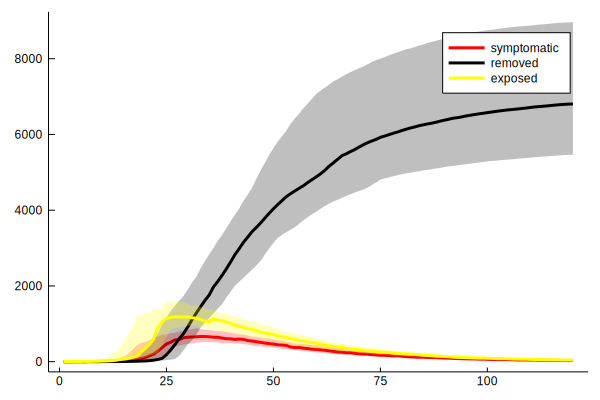

In [7]:
plot()
plotquantiles(It,:red,"symptomatic")
plotquantiles(Rt,:black,"removed")
plotquantiles(Et,:yellow,"exposed")

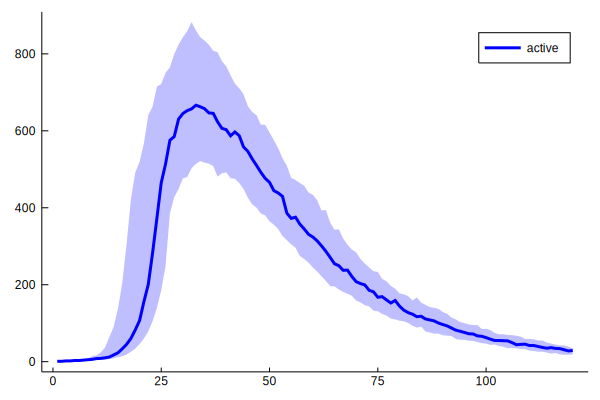

In [8]:
plot()
plotquantiles(It,:blue,"active")

In [9]:
It

120×50 Array{UInt64,2}:
 0x0000000000000000  0x0000000000000001  …  0x0000000000000001
 0x0000000000000000  0x0000000000000001     0x0000000000000001
 0x0000000000000000  0x0000000000000001     0x0000000000000002
 0x0000000000000001  0x0000000000000002     0x0000000000000001
 0x0000000000000000  0x0000000000000002     0x0000000000000001
 0x0000000000000000  0x0000000000000004  …  0x0000000000000002
 0x0000000000000002  0x0000000000000004     0x0000000000000002
 0x0000000000000003  0x0000000000000008     0x0000000000000002
 0x0000000000000003  0x000000000000000a     0x0000000000000001
 0x0000000000000003  0x000000000000000d     0x0000000000000004
 0x0000000000000003  0x0000000000000010  …  0x0000000000000007
 0x0000000000000003  0x0000000000000016     0x000000000000000d
 0x0000000000000006  0x0000000000000042     0x0000000000000014
                  ⋮                      ⋱  
 0x000000000000002b  0x0000000000000028     0x000000000000001b
 0x000000000000002c  0x0000000000000027     0x000

In [10]:
gridsize=1450
bamodel=barabasi_albert(gridsize^2, 3, 2)
ndays=150 #120 prediction (from patient(s) zere
nsims=100 #50 runs
i=1
cols=[:black, :blue, :cyan, :purple, :magenta, :green, :orange, :yellow, :pink, :red, :brown]
swswaps=[0, 0.001, 0.01, 0.02, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25];
for swp in swswaps 
    wattstrog=watts_strogatz(gridsize^2, 4, swp)
    St,Et,It,Rt=episim(bamodel,wattstrog,ndays,nsims) #switch between scale free and lattice (i.e. mixing to diffusion)
    plotquantiles(It,cols[i],"p=$(swswaps[i])")
    i += 1
end

100.0%┣████████████████████████████████████████┫ 100/100 [08:14<00:00, 0.2 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [07:52<00:00, 0.2 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [09:46<00:00, 0.2 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [09:20<00:00, 0.2 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [12:48<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [16:36<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [16:46<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [16:13<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [16:41<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [18:19<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [19:07<00:00, 0.1 it/s]


In [11]:
gridsize=1450
bamodel=barabasi_albert(gridsize^2, 3, 2)
ndays=150 #120 prediction (from patient(s) zere
nsims=100 #50 runs
swswaps=[0, 0.001, 0.01, 0.02, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25];
Sti=Array{Any,1}(undef,length(swswaps))
Eti=Array{Any,1}(undef,length(swswaps))
Iti=Array{Any,1}(undef,length(swswaps))
Rti=Array{Any,1}(undef,length(swswaps))
i=1
for swp in swswaps
    wattstrog=watts_strogatz(gridsize^2, 4, swp)
    St,Et,It,Rt = episim(bamodel,wattstrog,ndays,nsims) #switch between scale free and lattice (i.e. mixing to diffusion)
    Sti[i]=St[:,:]
    Eti[i]=Et[:,:]
    Iti[i]=It[:,:]
    Rti[i]=Rt[:,:]
    i += 1
end

100.0%┣████████████████████████████████████████┫ 100/100 [08:12<00:00, 0.2 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [10:10<00:00, 0.2 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [11:17<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [12:23<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [12:23<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [14:25<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [15:07<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [20:03<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [18:07<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [20:13<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [24:53<00:00, 0.1 it/s]


In [12]:
plot()
cols=[:black, :blue, :purple, :green, :orange, :yellow, :red]
for i=1:6
    print(i)
    plotquantiles(Sti[i],cols[i],"p=$(swswaps[i])")
end

123456

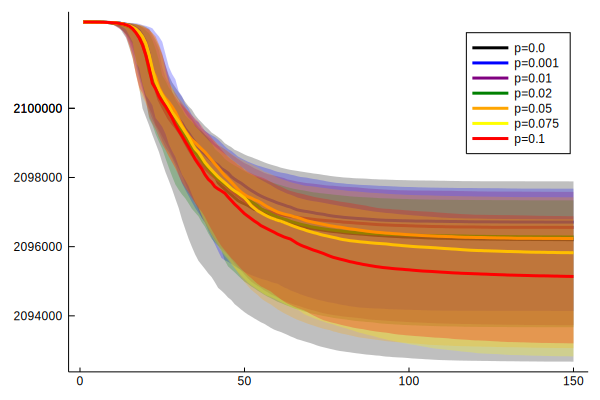

In [13]:
i=7
plotquantiles(Sti[i],cols[i],"p=$(swswaps[i])")

In [14]:
swswaps=[0, 0.001, 0.01, 0.02, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25];
cols=[:black, :blue, :cyan, :purple, :magenta, :green, :orange, :yellow, :pink, :red, :brown]



11-element Array{Symbol,1}:
 :black
 :blue
 :cyan
 :purple
 :magenta
 :green
 :orange
 :yellow
 :pink
 :red
 :brown

In [15]:
plot()
for i=[1 2 3 4 5 7 8 9 10]
    print(i)
    plotquantiles(Sti[i],cols[i],"p=$(swswaps[i])")
end

1234578910

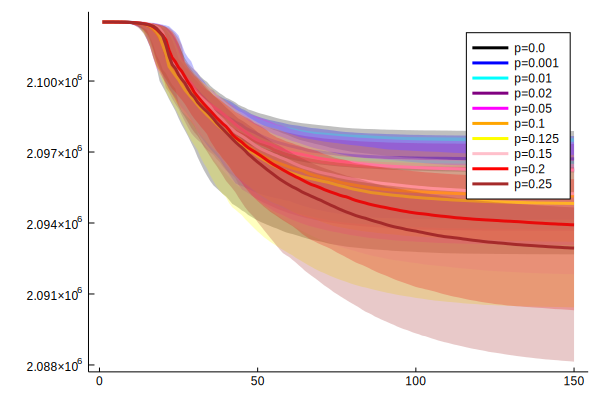

In [16]:
 i=11
plotquantiles(Sti[i],cols[i],"p=$(swswaps[i])")



In [17]:
plot()
for i=[1 2 3 4 5 7 8 9 10]
    print(i)
    plotquantiles(Iti[i],cols[i],"p=$(swswaps[i])")
end

1234578910

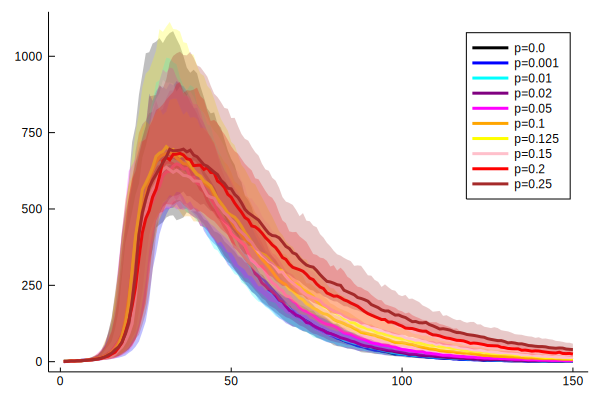

In [18]:
i=11
plotquantiles(Iti[i],cols[i],"p=$(swswaps[i])")



In [19]:
NSt,NEt,NIt,NRt = episim(bamodel,bamodel,ndays,nsims)

100.0%┣████████████████████████████████████████┫ 100/100 [30:50<00:00, 0.1 it/s]


(UInt64[0x00000000002014df 0x00000000002014df … 0x00000000002014dd 0x00000000002014df; 0x00000000002014dd 0x00000000002014dd … 0x00000000002014dd 0x00000000002014df; … ; 0x000000000015004f 0x000000000014ec26 … 0x000000000014e1ed 0x000000000014d5c6; 0x000000000014fe73 0x000000000014ea87 … 0x000000000014e088 0x000000000014d411], UInt64[0x0000000000000004 0x0000000000000003 … 0x0000000000000006 0x0000000000000005; 0x0000000000000005 0x0000000000000005 … 0x0000000000000005 0x0000000000000004; … ; 0x0000000000001354 0x0000000000000fce … 0x000000000000101d 0x0000000000001060; 0x00000000000012c0 0x0000000000000f2f … 0x0000000000000f55 0x0000000000000fe6], UInt64[0x0000000000000001 0x0000000000000002 … 0x0000000000000001 0x0000000000000000; 0x0000000000000002 0x0000000000000002 … 0x0000000000000002 0x0000000000000001; … ; 0x0000000000000d4f 0x0000000000000b6d … 0x0000000000000b5e 0x0000000000000b64; 0x0000000000000c91 0x0000000000000ad2 … 0x0000000000000aab 0x0000000000000ad8], UInt64[0x000000

In [20]:
function diffmat(A)
    A[2:end,:]-A[1:end-1,:]
end

diffmat (generic function with 1 method)

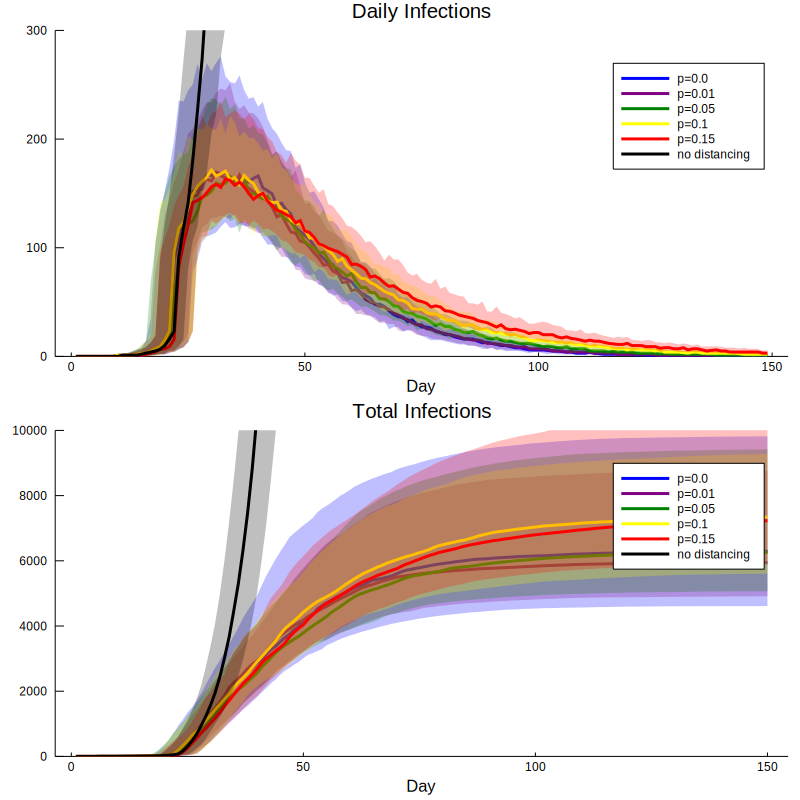

In [21]:
p1=plot(title="Daily Infections", ylims=(0,300),xlabel="Day")
dothese=[1 3 5 7 9]
for i=dothese
    plotquantiles(diffmat(Rti[i]),cols[i+1],"p=$(swswaps[i])")
end
plotquantiles(diffmat(NRt),:black,"no distancing")


p2=plot(title="Total Infections", ylims=(0,10000),xlabel="Day")
for i=dothese
    plotquantiles(Rti[i],cols[i+1],"p=$(swswaps[i])")
end
plotquantiles(NRt,:black,"no distancing")

plot(p1,p2,layout=(2,1),size=(800, 800))

In [22]:
savefig("distancing-error")